In [1]:
  '''
Build a LSTM model to perform sentiment analysis on IMDB dataset.
Save the model to the disk for further analysis.
'''
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [2]:
VOCAB_SIZE = 10000
PAD_VALUE = 0
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_SEQ_LEN = 150
WORD_VEC_DIMS = 50
LSTM_UNITS = 64
word_index = {}
reverse_word_index = {}

In [3]:
input_seq = tf.placeholder(tf.int32, [None, MAX_SEQ_LEN], name='input_seq')
target_class = tf.placeholder(tf.float32, [None, 1], name='target_class')

In [4]:
def loadData():
    imdb = keras.datasets.imdb

    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

    train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
    test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

    valid_data = train_data[0:5000]
    valid_labels = train_labels[0:5000]

    train_data = train_data[5000:]
    train_labels = train_labels[5000:]

    return imdb, train_data, train_labels, valid_data, valid_labels, test_data, test_labels

In [5]:
def decodeExampleText(imdb, text):
    '''
    for given text, returns decoded form.
    numbers=>words
    '''
    global word_index
    global reverse_word_index
    word_index = imdb.get_word_index()
    # The first indices are reserved
    word_index = {k:(v+3) for k,v in word_index.items()} 
    word_index["<PAD>"] = PAD_VALUE
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown
    word_index["<UNUSED>"] = 3

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
def preprocessData(train_data, valid_data, test_data):
    '''
    pad the arrays so they all have the same length,
    then create an integer tensor of shape max_length * num_reviews.
    we can use an embedding layer capable of handling this shape as the first layer in our network.
    '''

    train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    valid_data = keras.preprocessing.sequence.pad_sequences(valid_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=PAD_VALUE, padding='post', maxlen=MAX_SEQ_LEN)
    
    train_data = np.reshape(train_data, (train_data.shape[0], MAX_SEQ_LEN))
    valid_data = np.reshape(valid_data, (valid_data.shape[0], MAX_SEQ_LEN))
    test_data = np.reshape(test_data, (test_data.shape[0], MAX_SEQ_LEN))

    return train_data, valid_data, test_data

In [7]:
def buildModel():
    '''
    returns output, cost and optimizer as tensor ops.
    '''
    # embedding layer
    word_vec = tf.Variable(tf.truncated_normal([VOCAB_SIZE, WORD_VEC_DIMS]), dtype=tf.float32, name='Word-Vectors')
    input_vec = tf.nn.embedding_lookup(word_vec, input_seq)

    # rnn lstm layer
    rnn_cell = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    rnn_cell = tf.contrib.rnn.DropoutWrapper(cell=rnn_cell, output_keep_prob=0.5)

    # finally, the rnn put together
    output, _ = tf.nn.dynamic_rnn(rnn_cell, input_vec, dtype=tf.float32)
    
    output = tf.layers.flatten(output)

    output = tf.layers.dense(output, 32)
    output = tf.nn.relu(output)

    output = tf.layers.dense(output, 1)
    output = tf.nn.sigmoid(output)

    loss = tf.losses.sigmoid_cross_entropy(target_class, output)
   
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    # a list of metrics to measure accuracy, precision, recall, f1-score
    metrics = []

    round_output = tf.round(output)
    
    accuracy = tf.metrics.accuracy(target_class, round_output, name='Accuracy')
   
    precision = tf.metrics.precision(target_class, round_output, name='Precision')
  
    recall = tf.metrics.recall(target_class, round_output, name='Recall')
    
    metrics.append(accuracy)
    metrics.append(precision)
    metrics.append(recall)

    return optimizer, loss, output, metrics

In [8]:
imdb, train_x, train_y, valid_x, valid_y, test_x, test_y = loadData()
train_x, valid_x, test_x = preprocessData(train_x, valid_x, test_x)

optimizer, loss, output, metrics = buildModel()

num_batches = train_x.shape[0] // BATCH_SIZE

initializer_g = tf.global_variables_initializer()
initializer_l = tf.local_variables_initializer()

sess = tf.Session()

sess.run([initializer_g, initializer_l])

for epoch in range(NUM_EPOCHS):
    print("Epoch {}".format(epoch))

    for batch in range(0, num_batches):
        l = batch*BATCH_SIZE
        r = min((batch+1)*BATCH_SIZE, train_x.shape[0]-1)

        batch_x = train_x[l:r]
        batch_y = train_y[l:r]

        _, _, _, _ = sess.run([optimizer] + metrics, {input_seq: batch_x, target_class: batch_y})

    # log summaries every epoch
    acc_train, prec_train, rec_train = sess.run(metrics, {input_seq: train_x, target_class: train_y})
    acc_valid, prec_valid, rec_valid = sess.run(metrics, {input_seq: valid_x, target_class: valid_y})

    # print metrics
    print("Training: Acc - {} | Prec - {} | Rec - {}".format(acc_train[0], prec_train[0], rec_train[0]))
    print("Validation: Acc - {} | Prec - {} | Rec - {}".format(acc_valid[0], prec_valid[0], rec_valid[0]))


Epoch 0
Training: Acc - 0.5775741338729858 | Prec - 0.7419354915618896 | Rec - 0.23150478303432465
Validation: Acc - 0.6042834520339966 | Prec - 0.8262053728103638 | Rec - 0.2593393325805664
Epoch 1
Training: Acc - 0.6473142504692078 | Prec - 0.8258086442947388 | Rec - 0.3706827163696289
Validation: Acc - 0.6776160597801208 | Prec - 0.852206289768219 | Rec - 0.4271099269390106
Epoch 2
Training: Acc - 0.703932523727417 | Prec - 0.8575373888015747 | Rec - 0.48721832036972046
Validation: Acc - 0.7268444299697876 | Prec - 0.8650886416435242 | Rec - 0.5355857610702515
Epoch 3
Training: Acc - 0.7449377775192261 | Prec - 0.8702126741409302 | Rec - 0.5742232203483582
Validation: Acc - 0.7599043846130371 | Prec - 0.8783729672431946 | Rec - 0.6018074750900269
Epoch 4
Training: Acc - 0.7726331353187561 | Prec - 0.8833507895469666 | Rec - 0.6269375681877136
Validation: Acc - 0.7835380434989929 | Prec - 0.886236846446991 | Rec - 0.6492716073989868
Epoch 5
Training: Acc - 0.7928090691566467 | Prec -

Training: Acc - 0.9224201440811157 | Prec - 0.9529252648353577 | Rec - 0.8883835077285767
Validation: Acc - 0.9228484630584717 | Prec - 0.9530829787254333 | Rec - 0.8891203999519348
Epoch 45
Training: Acc - 0.9231143593788147 | Prec - 0.9530074000358582 | Rec - 0.8897626996040344
Validation: Acc - 0.9235042929649353 | Prec - 0.9533073306083679 | Rec - 0.8902720212936401
Epoch 46
Training: Acc - 0.9237551689147949 | Prec - 0.9534726142883301 | Rec - 0.8906343579292297
Validation: Acc - 0.9241966605186462 | Prec - 0.9537578821182251 | Rec - 0.8912671208381653
Epoch 47
Training: Acc - 0.9244580864906311 | Prec - 0.9538672566413879 | Rec - 0.8917087912559509
Validation: Acc - 0.9248972535133362 | Prec - 0.954138457775116 | Rec - 0.892350971698761
Epoch 48
Training: Acc - 0.9251562356948853 | Prec - 0.9542179107666016 | Rec - 0.892818033695221
Validation: Acc - 0.9255782961845398 | Prec - 0.9544860124588013 | Rec - 0.8934269547462463
Epoch 49
Training: Acc - 0.925819456577301 | Prec - 0.954

In [169]:
from lime.lime_text import LimeTextExplainer, IndexedString, TextDomainMapper
class_names = ['negative','positive']
explainer = LimeTextExplainer(class_names=class_names, split_expression=r'\s+', bow=True)

def makePrediction(strings):
    '''
    takes a list of d strings 
    and outputs a (d, k) numpy array with prediction probabilities, 
    where k is the numb/er of classes
    '''
    # convert d strings into shape (d,MAX_SEQ_LEN)
    global word_index
    for j in range(0,len(strings)):
        strings[j] = strings[j].split(' ')
        for i in range(0,len(strings[j])):
            if strings[j][i] in word_index.keys():
                strings[j][i] = word_index[strings[j][i]]
            else:
                strings[j][i] = word_index["<UNK>"]
    strings = np.array(strings)
    
    # calculate the output on strings
    pred = sess.run(output, {input_seq: strings})
    
    # reshape it into (d,NUM_CLASSES) corresponding to d output probability distributions
    pred = pred.tolist()
    for i in range(0, len(pred)):
        pred[i].insert(0,1-pred[i][0])
    
    return np.array(pred)


In [170]:
import random
NUM_SAMPLES = 3
strings_to_explain = []
correct_op = []
for i in range(0,NUM_SAMPLES):
    rand_ind = random.randint(0,train_x.shape[0]-1)
    
    sample_x = train_x[rand_ind]
    sample_y = train_y[rand_ind]
    
    sample_x  = decodeExampleText(imdb, sample_x)
    
    strings_to_explain.append(sample_x)
    correct_op.append(sample_y)

[('great', 0.4276825826189524), ('the', 0.16280083894813419), ('love', 0.1463741732437219), ('fathers', 0.12185221977663897), ('see', 0.11796623088174829)]


[('better', -0.0026119672460036517), ('lab', -0.002467121415762321), ("can't", -0.0022363324096884105), ('limited', -0.0022360886767083766), ('hard', -0.002091913448354051)]


[('yawn', -0.03824756391479645), ('desperately', -0.029210863772866132), ('italians', -0.02447484641811902), ('set', -0.024391785600730864), ('hotel', -0.02183597807836732)]


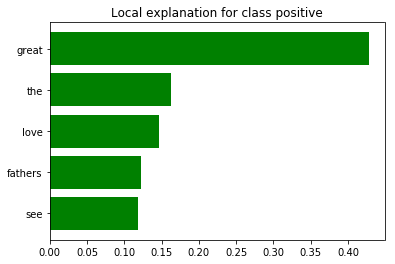

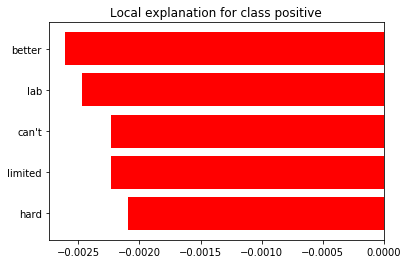

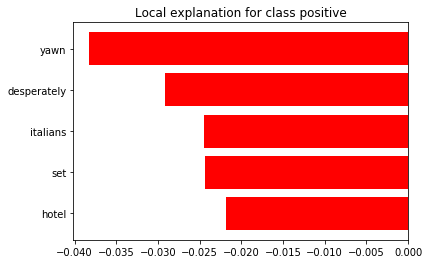

In [171]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

strings = list(strings_to_explain)
for text in strings:
    exp = explainer.explain_instance(text, makePrediction, labels=(1,), num_features=5, num_samples=1000)

    fig = exp.as_pyplot_figure()
    exp.show_in_notebook(labels=[1])
    
    print(exp.as_list())
    ind_string = IndexedString(text, split_expression=r'\s+', bow=True)
    # print(ind_string.positions)
    # print(ind_string.inverse_vocab)
    # txt_dmp_map = TextDomainMapper(ind_string)

In [172]:
# Todo: 
# Calculate Performance metrics on test set (done)
# LIME explanations (done)
# Stability of LIME explanations on test set (---)
# Shapley values
# Stability of Shapley values on test set
# Party!

In [173]:
# Calculate Performance metrics on test set
acc_test, prec_test, rec_test = sess.run(metrics, {input_seq: test_x, target_class: test_y})

# print metrics
print("Test: Acc - {} | Prec - {} | Rec - {}".format(acc_test[0], prec_test[0], rec_test[0]))

Test: Acc - 0.9207382202148438 | Prec - 0.948106586933136 | Rec - 0.8898606300354004


In [189]:
# Calculate Stability on test set
# Stability = Change in explanations / Change in input
# Average stability over the test set seems a good estimation

def noisifyExample(example, num_samples=100, noise=5):
    '''
    for a given example text,
    return a list of texts of size num_samples,
    where each text is same as example except noise amount of words are removed randomly.
    '''
    noisy_examples = []
    
    while len(noisy_examples) < num_samples:
        indices_to_remove = set()
        while len(indices_to_remove) < noise:
            indices_to_remove.add(random.randint(0,MAX_SEQ_LEN-1))
        new_exmp = example.split(" ")
        for ind in indices_to_remove:
            new_exmp[ind] = "<PAD>"
        new_exmp = " ".join(new_exmp)
        noisy_examples.append(new_exmp)
        
    return noisy_examples

def vectorDifference(vec1, vec2):
    '''
    return Mean Square Error between vec1 and vec2
    '''
    assert len(vec1) == len(vec2)
    n = len(vec1)
    
    # normalize vec1 and vec2 unless zero vectors
    sum1 = sum(vec1)
    sum2 = sum(vec2)
    if sum1:
        vec1 = list(map(lambda x: x/sum1, vec1))
    if sum2:
        vec2 = list(map(lambda x: x/sum2, vec2))
    
    # compute mse
    mse = [vec1[ind]-vec2[ind] for ind in range(n)] # difference
    mse = [x**2 for x in mse] # squared
    mse = sum(mse) # sum
    mse /= n # averaged
    
    return mse
    

def calculateStability(example, num_samples, noises):
    '''
    example: original text
    num_samples: size of neighborhood around 'example'
    noises: list of integers, each indicating the amount of noise
    
    returns: average stability, which is a dictionary.
             maps noise to avg stability of 'example'.
    
    stability = MSE(exp1,exp2) * noise ** 0.5
    
    change in input = #words removed from original input (same as noise)
    change in explanation = M.S.E calculated using vectorDifference()
    '''
    assert num_samples > 0
    
    # get noisy_examples for example
    noisy_examples = {}
    for noise in noises:
        noisy_examples[str(noise)] = noisifyExample(example, num_samples, noise) # returns a list of shape num_samples x MAX_SEQ_LEN
    
    # get explanation for example
    explanation = explainer.explain_instance(example, makePrediction, labels=(1,), num_features=5, num_samples=1000)
    explanation = explanation.as_list()
    explanation.sort(key = lambda x:x[0]) # sort by words
    
    # get words from explanation
    words = [exp[0] for exp in explanation]
    words = set(words)
    
    # get explanations for noisy_examples
    noisy_explanations = {}
    for noise in noises:
        noisy_explanations[str(noise)] = []
        
    for noise in noises:
        for noisy_example in noisy_examples[str(noise)]:
            noisy_exp = explainer.explain_instance(noisy_example, makePrediction, labels=(1,), num_features=5, num_samples=1000)
            noisy_exp = noisy_exp.as_list()

            noisy_words = [exp[0] for exp in noisy_exp]
            noisy_words = set(noisy_words)

            # filter noisy_exp 
            for word in words:
                if word not in noisy_words:
                    noisy_exp.append((word,0))
            noisy_exp = list(filter(lambda x:x[0] in words, noisy_exp))

            noisy_exp.sort(key = lambda x:x[0]) # sort by words
            noisy_explanations[str(noise)].append(noisy_exp)

    
    # calculate stability for each noisy explanation w.r.t explanation
    stabilities = {}        
        
    for noise in noises:
        stabilities[str(noise)] = []
        for noisy_explanation in noisy_explanations[str(noise)]:
            # convert explanation and noisy_exp into vector of weights
            vec1 = list(map(lambda x: x[1], explanation))
            vec2 = list(map(lambda x: x[1], noisy_explanation))

            # compute vector difference
            mse = vectorDifference(vec1, vec2)

            # compute stability
            stability = mse * noise ** 0.5
            stabilities[str(noise)].append(stability)
        stabilities[str(noise)] = sum(stabilities[str(noise)])
    return stabilities

In [192]:
# Stability of LIME explanations on test set
# NOTE: these computations are expensive so test set will be reduced to 1000 examples

# range of noises
noises = [x for x in range(5,11)]

# no. of noisy samples for each example in test set
num_samples = 30

# dictionary noise(key)->test_stability(value)
test_stabilities = {}

# initialize dictionary
for noise in noises:
    test_stabilities[str(noise)] = 0

# compute stability on test set over noises
for i in range(0,1000): # calculate stability for each of 1000 test examples
    x = test_x[i]
    x  = decodeExampleText(imdb, x)
    stb = calculateStability(x, num_samples, noises) # returns a dictionary key(noise) -> val(avg.stability)
    print(stb)
    for noise in noises:
        test_stabilities[str(noise)] += stb[str(noise)]

for noise in noises:
    test_stabilities[str(noise)] /= 1000
    print("Stability on test set for noise {} : {}".format(noise, test_stabilities[str(noise)]))

{'5': 2.5500998021500654, '6': 3.24010975354471, '7': 3.357949517977768, '8': 3.2928566962361554, '9': 4.313518247739719, '10': 4.23782822061375}
{'5': 2.8979790355573383, '6': 3.2831315786428403, '7': 3.803599582543201, '8': 3.8785304757951464, '9': 4.206505343853837, '10': 4.275640535769435}
{'5': 3.2756651714958935, '6': 2.1677135140519175, '7': 3.451305246261417, '8': 3.3245073283033784, '9': 4.619172277512167, '10': 4.771199371403653}
{'5': 3.8672798518016425, '6': 6.253794701944378, '7': 6.116057637513623, '8': 6.183576376522368, '9': 6.427891224539642, '10': 7.254293952214091}
{'5': 1.1265401351275193, '6': 1.2994001923261023, '7': 1.6858458541174113, '8': 1.509390515657309, '9': 1.6723587424639599, '10': 2.0855373732268765}
{'5': 1.8397767844794608, '6': 2.3791021619806614, '7': 2.5495994046204578, '8': 2.94482600013538, '9': 4.330305790224873, '10': 2.6795151646554447}
{'5': 5.186791515841721, '6': 6.021223840301604, '7': 5.598797278250724, '8': 7.738254447154136, '9': 6.76812

{'5': 1.1095521848943453, '6': 1.3355846302974916, '7': 1.8081489692476609, '8': 1.9605371539955905, '9': 1.9395734302042344, '10': 2.5824796844058513}
{'5': 14584.903332198572, '6': 362.381844051115, '7': 101.85245889971672, '8': 338.92652741647834, '9': 404.38346365490685, '10': 226.92970158327697}
{'5': 1.9443101242478933, '6': 2.7771401216875926, '7': 2.2075629388164413, '8': 2.9167033951087293, '9': 3.0391223901003115, '10': 3.2292004594409454}
{'5': 6.170874436870122, '6': 6.408783028196179, '7': 7.674427013697366, '8': 8.30623493413853, '9': 9.86715690705087, '10': 9.877078803092903}
{'5': 6.461982982911237, '6': 6.6391033068711405, '7': 7.205745148614054, '8': 9.503165976623078, '9': 9.342952499965369, '10': 9.13028644712189}
{'5': 10.171855801457085, '6': 11.460217669493353, '7': 11.309235036563665, '8': 12.899811393490435, '9': 12.987692039433329, '10': 12.736169402666608}
{'5': 6.7363917872576735, '6': 6.273548302951168, '7': 7.019768842243203, '8': 6.944245035701698, '9': 7

{'5': 4.03365589613996, '6': 3.680333518035592, '7': 5.101045008795159, '8': 6.057831591880599, '9': 5.540420874973259, '10': 6.860582502069697}
{'5': 6.288373934331295, '6': 5.817217651510934, '7': 6.992429670842615, '8': 9.338716557641243, '9': 7.567680240570141, '10': 9.281456828780081}
{'5': 14.936813913248997, '6': 5.3380290911308625, '7': 8.101249939076537, '8': 8.679366629931614, '9': 10.610374240037185, '10': 15.668854833208236}
{'5': 6.956430587890383, '6': 7.74593750114155, '7': 9.46087100506845, '8': 8.152734550244169, '9': 9.339012369159756, '10': 10.165195458451953}
{'5': 3915.6331924810174, '6': 827.6588851491741, '7': 3079.601866610481, '8': 552.5454283530743, '9': 2117.53594993118, '10': 17031.487707173674}
{'5': 3171.816051153334, '6': 1910.0856433474041, '7': 2556.6550171606377, '8': 2179.6826218840374, '9': 4405.033563370052, '10': 2864.340805611859}
{'5': 7.1137047397125635, '6': 6.923554025586007, '7': 28.85789861490893, '8': 50.51168609907668, '9': 6.9683274563131

{'5': 4.6092761113334335, '6': 5.795963039423727, '7': 5.590737767292921, '8': 6.9146565498021335, '9': 7.602495482043004, '10': 8.68577321404445}
{'5': 5.292693060930151, '6': 7.650558539058356, '7': 8.899705188510993, '8': 8.305179211020297, '9': 9.497859524419557, '10': 9.203951904288665}
{'5': 9125.724377594344, '6': 1014.7410294220151, '7': 244.35557199502264, '8': 127075.7450642842, '9': 2659.819851173772, '10': 6246.554511776967}
{'5': 7.091741050056802, '6': 7.213318056388894, '7': 8.380976342248745, '8': 7.552307646142451, '9': 10.125166647781661, '10': 7.710593409369194}
{'5': 6.96024800863867, '6': 7.515454685691472, '7': 7.937612431682814, '8': 8.473401285069938, '9': 8.754106280712689, '10': 8.964357183239752}
{'5': 5.493492231922108, '6': 7.161781360287492, '7': 8.094440635981993, '8': 8.650570890785897, '9': 9.214180469463251, '10': 9.232938677669294}
{'5': 0.6973191232362225, '6': 1.0068866870434052, '7': 1.1749770425806263, '8': 1.3260838338750176, '9': 1.2044786428114

{'5': 7.492956871855804, '6': 6.483595088751188, '7': 8.440327303503562, '8': 8.03509670002583, '9': 8.64062576633668, '10': 9.355150771823386}
{'5': 0.8569357239852676, '6': 1.014547758944373, '7': 1.2514582042946785, '8': 1.019493855318318, '9': 1.4514244831061431, '10': 1.6425050815679527}
{'5': 6.723655556018463, '6': 6.88526935673947, '7': 7.343776708455045, '8': 8.007911099760136, '9': 8.334239748928322, '10': 9.19798255566499}
{'5': 191.271509624414, '6': 781.9125484834174, '7': 8209.481820160612, '8': 699.3693938492698, '9': 6765.199400968152, '10': 14537.740587908673}
{'5': 11.96187051823385, '6': 12.258754391126525, '7': 21.22968564497165, '8': 16.19326365322554, '9': 13.365055421174295, '10': 15.10357525532407}
{'5': 3.695475532826727, '6': 2.5418330882851206, '7': 2.0982918441278007, '8': 4.0300232860632965, '9': 8.680591333259727, '10': 4.436746372539589}
{'5': 395.9347605008211, '6': 1167.6875636146294, '7': 540.785512308202, '8': 2004.3252471840783, '9': 13904.2339261356

{'5': 6.449754750854159, '6': 6.098487791220449, '7': 6.466370886809809, '8': 7.274124963166232, '9': 6.255396705693142, '10': 7.004927344812322}
{'5': 6.673872476900092, '6': 7.998213040819331, '7': 7.814544015988505, '8': 9.47580910075328, '9': 8.62154747844589, '10': 9.65570213364362}
{'5': 6.45081703780061, '6': 7.516749634573259, '7': 8.352283932391645, '8': 8.752333546074052, '9': 7.512737167842374, '10': 9.375844573418304}
{'5': 2.065365881076243, '6': 2.65558359121356, '7': 2.3234150304896026, '8': 2.6599773961707402, '9': 2.9854512762388428, '10': 3.74384510984462}
{'5': 4.029862805156254, '6': 4.076784582719354, '7': 3.645682670737955, '8': 4.8508229303424, '9': 4.701607809123038, '10': 4.207363228203425}
{'5': 0.5997858134372116, '6': 0.6351716462332045, '7': 1.030852232134781, '8': 1.2077774471752607, '9': 0.9023524088913013, '10': 1.197745678123525}
{'5': 6.339473528541505, '6': 8.20332642355166, '7': 5.94259556389694, '8': 6.938294271685135, '9': 8.699579903814488, '10': 

{'5': 3.9385911835619303, '6': 4.480678251833057, '7': 3.7403836675850584, '8': 5.8627265698077435, '9': 3.4405057059398976, '10': 4.729486458140863}
{'5': 5.655813180132001, '6': 18.827350652589605, '7': 42.292309514726625, '8': 5.498048027239425, '9': 1256.8653921492437, '10': 17.537183783123226}
{'5': 6990.021784048087, '6': 68049073.78570992, '7': 1583.667870067599, '8': 6182.944309505204, '9': 17627.336496794043, '10': 177070.516432465}
{'5': 11.774076507640595, '6': 116.20845502490994, '7': 1539.338355280281, '8': 30.396850512227775, '9': 21.316248754519343, '10': 12.404260596104912}
{'5': 4.079246373188324, '6': 5.765403351016434, '7': 5.370186445744534, '8': 7.357146721488436, '9': 7.295037444775917, '10': 11.821799065028722}
{'5': 4.770318414968932, '6': 14.103199647739304, '7': 31.04220198462267, '8': 22.34264545288442, '9': 9.063543721322237, '10': 10.889182669744905}
{'5': 6.594956725363737, '6': 6.442970700468902, '7': 7.369256252394929, '8': 8.909908142973622, '9': 8.2194

{'5': 4.1384638718469065, '6': 5.629019700380481, '7': 5.146165615708526, '8': 5.620173937957114, '9': 5.739448733614527, '10': 6.320528411495088}
{'5': 2.01435956240746, '6': 1.7988598518156718, '7': 2.4271934454883706, '8': 2.675436512369074, '9': 2.373249325263558, '10': 2.690262660998553}
{'5': 4.56140938738386, '6': 3.4430581502831403, '7': 5.84508770115744, '8': 8.468447412886913, '9': 6.361774434631519, '10': 7.6861467156398975}
{'5': 1.4220117160800492, '6': 1.2403577366114718, '7': 1.6041173682268213, '8': 1.6047981649704879, '9': 1.6358617210175932, '10': 2.0100798457191678}
{'5': 7.3440162664636865, '6': 6.955259669085223, '7': 11.393722881064404, '8': 9.627986373629696, '9': 75.72859272707502, '10': 73.58102641280806}
{'5': 89677.72301315871, '6': 4826.097327368283, '7': 3875.3055525713276, '8': 3581.442274122491, '9': 3520.151097755892, '10': 4809.577551302971}
{'5': 6.326874057466317, '6': 7.302054290907729, '7': 8.516924864437625, '8': 8.56371130535434, '9': 9.2348514910

{'5': 2.6482179848459233, '6': 4.0122803948670835, '7': 4.7012290332673565, '8': 3.822233785550337, '9': 5.360041850402248, '10': 4.276390706664452}
{'5': 50.46040859484821, '6': 92.18136204753097, '7': 10.848456628653432, '8': 10.884819960494884, '9': 20.38923060593754, '10': 43.40400521668535}
{'5': 0.5204435669670906, '6': 0.5849229259071946, '7': 0.5225322235804575, '8': 0.5675463877784177, '9': 0.7536050819408404, '10': 0.7167513999488945}
{'5': 6.154337901954003, '6': 5.82719404550727, '7': 6.711278855077912, '8': 6.412262245909866, '9': 7.323401339035506, '10': 8.699702990675986}
{'5': 4.321471435402088, '6': 4.946691873511032, '7': 7.786024225893676, '8': 7.414827979303631, '9': 7.816321458123089, '10': 6.188919818182086}
{'5': 154.7177023853747, '6': 34.13192116124988, '7': 45.68832802963033, '8': 46.36454258518506, '9': 160.4330407108504, '10': 332.3858513405853}
{'5': 25747.669687822574, '6': 363.1088252982219, '7': 55.58704209783802, '8': 17.643139441617766, '9': 173.939753

{'5': 0.5932458248842704, '6': 0.7526998340444945, '7': 0.9325397842529962, '8': 1.4417180683856614, '9': 0.9387388409210047, '10': 1.4998520494699557}
{'5': 3.8981631750571704, '6': 3.0997897682797277, '7': 4.187258751879579, '8': 4.993633023453727, '9': 5.730662426380587, '10': 5.320501807834316}
{'5': 7.337070099619708, '6': 7.558523396899688, '7': 8.210364278407951, '8': 8.901506357079105, '9': 9.298944039955773, '10': 10.282321145938914}
{'5': 2093.2162683779097, '6': 11861.325239556336, '7': 2337.451469866111, '8': 5642.063431087282, '9': 1606.2905018096483, '10': 105683.356605883}
{'5': 44.73563227910037, '6': 157.083464004742, '7': 2379.2594757377224, '8': 212.16411977356464, '9': 1059.9060125574656, '10': 154.07631729778507}
{'5': 0.6280045703121252, '6': 1.002789971486845, '7': 1.0738905749402494, '8': 0.9974112958276505, '9': 0.8797046771515724, '10': 1.0262260518587656}
{'5': 2.4970357172230364, '6': 3.433423769322621, '7': 3.7038689032285186, '8': 4.571768966920903, '9': 3

{'5': 13.696023326003171, '6': 326.65072403161713, '7': 34.17861912761862, '8': 6737.709505076956, '9': 1065.3606226289712, '10': 12.37285850597621}
{'5': 6.4532670689404465, '6': 4.974243500100626, '7': 5.87913177189133, '8': 5.969370263541884, '9': 7.044164266706806, '10': 7.109021741136102}
{'5': 9.392571999854079, '6': 9.597963135540297, '7': 9.852059517778743, '8': 10.320968431394972, '9': 13.107932519195401, '10': 12.185938535823354}
{'5': 488898.06124016485, '6': 772.1669692590755, '7': 9948.70734168527, '8': 45936.13509464082, '9': 14102.415325408123, '10': 3281937.282641864}
{'5': 7.068740074255421, '6': 7.304626973269102, '7': 7.977099658511657, '8': 8.404525641933986, '9': 9.339060799087372, '10': 9.689391756092965}
{'5': 2041.4232052765576, '6': 2852.117680289322, '7': 1934.96275838043, '8': 4494.366138482464, '9': 21980.00342468781, '10': 20053.6911578881}
{'5': 49.85516987416232, '6': 277.09826971633, '7': 628.5352964598835, '8': 725.7820451023342, '9': 664.0634441415123,

{'5': 26.285112298940458, '6': 8.78809496294306, '7': 10.23347024455394, '8': 8.733669599561383, '9': 50.82007042736192, '10': 403.848558743952}
{'5': 3.5970412521969726, '6': 2.939730582619096, '7': 3.429599846479447, '8': 4.730116090942803, '9': 4.764415070375837, '10': 4.713266574653002}
{'5': 4.506437878899228, '6': 4.762555109703148, '7': 6.105580941743008, '8': 4.976912645133955, '9': 6.648337486942125, '10': 7.937922523486763}
{'5': 1.8264903470634362, '6': 2.066788162034439, '7': 2.9213072277533203, '8': 3.1896736735900513, '9': 2.8782303966855443, '10': 3.5669609388018624}
{'5': 0.7688507128007559, '6': 0.5957934666951423, '7': 0.8065556452356762, '8': 1.019124910730955, '9': 1.0813374169800813, '10': 1.1599082406077903}
{'5': 1.2697204545388916, '6': 1.6069831895805005, '7': 2.3720570329355244, '8': 1.4494391792046453, '9': 2.41345654463213, '10': 2.248842205613486}
{'5': 47.02068217735961, '6': 611.2377161629039, '7': 64.5085792356358, '8': 43.859383379528666, '9': 5019.6148

{'5': 4.356644295414308, '6': 5.384704266426581, '7': 4.482387750007278, '8': 5.473063625294514, '9': 5.769897634181598, '10': 5.4754238635922245}
{'5': 3.2576494290415345, '6': 4.565629749273337, '7': 4.314656277816133, '8': 3.8066651047415454, '9': 5.76586650285083, '10': 5.780437132905673}
{'5': 5.535547155590504, '6': 8.844084662651403, '7': 7.619106577674806, '8': 7.455700419790561, '9': 8.840207304763492, '10': 11.220158930577602}
{'5': 1.3846257861908822, '6': 2.5840982681477147, '7': 2.57634939743204, '8': 1.90005368102936, '9': 3.1101405924874075, '10': 2.6849812592777997}
{'5': 7.378251120603024, '6': 7.738690222701645, '7': 8.0281372501828, '8': 7.714831451055773, '9': 8.189778180358257, '10': 8.285070674747692}
{'5': 2765.530078658399, '6': 3543.129965769274, '7': 67.02081572957547, '8': 1186.17662575847, '9': 5096.1731946705, '10': 410.58589637183627}
{'5': 6.588275010163638, '6': 7.0050833596718665, '7': 9.749945367679205, '8': 9.572076394750473, '9': 9.764626830477757, '

{'5': 4.560753575932979, '6': 4.219591101184117, '7': 6.669662745459325, '8': 6.193552672793774, '9': 8.94641661217845, '10': 8.375697002461662}
{'5': 109.64565179087182, '6': 103.84885936038135, '7': 12.554260572915071, '8': 17.26069433881528, '9': 10.234344458338741, '10': 11.52892550759182}
{'5': 5.797990731925752, '6': 5.414568441840643, '7': 5.542787130819635, '8': 7.555779327177045, '9': 7.91992582122976, '10': 6.651804957040982}
{'5': 3.207248272414592, '6': 4.039782781162091, '7': 4.875754247253358, '8': 4.296864584517371, '9': 4.225367910851431, '10': 4.816447773094705}
{'5': 2540.3259589191493, '6': 279299.0369014323, '7': 695362.7957016565, '8': 6805.204759989241, '9': 155473.3469100804, '10': 23654.194108904714}
{'5': 1.7224779745994057, '6': 2.391486520891548, '7': 2.150372747321971, '8': 3.0097973784851404, '9': 4.363643830780898, '10': 2.7763945089478157}
{'5': 2.7053165791096805, '6': 3.2198618894154225, '7': 3.5793008955858028, '8': 4.351713525780285, '9': 3.0439659317

{'5': 20.21516010180728, '6': 135.39173121040875, '7': 2.505463828716914, '8': 9.907751642499866, '9': 13.812438248706437, '10': 4.628092964338309}
{'5': 7.708588180975532, '6': 6.723683982809675, '7': 8.522457740972557, '8': 8.211480023130632, '9': 10.659548055625839, '10': 8.810707764298407}
{'5': 6.413973255032673, '6': 8.917721096911498, '7': 8.167649963641425, '8': 10.695334710127208, '9': 11.259064817685926, '10': 9.658250489701087}
{'5': 713.5079676487836, '6': 1591.5628720389498, '7': 5756.840890899252, '8': 13534.92704120931, '9': 371555.7836643354, '10': 2921.0127149900663}
{'5': 7.324752963308575, '6': 5.752032950190443, '7': 8.549297017344745, '8': 9.363970122424202, '9': 8.023748815760253, '10': 9.588580251844485}
{'5': 5.480522200196329, '6': 6.264386434539798, '7': 5.927016321852541, '8': 7.2962570253395835, '9': 8.310667423541997, '10': 7.669194596336392}
{'5': 19.263268187574102, '6': 12.223760935607286, '7': 17.29905478527921, '8': 51.3105789651811, '9': 24.3443733987

{'5': 7.06603408777852, '6': 8.485201125864323, '7': 7.068513726047777, '8': 9.317463243821804, '9': 7.967244113296835, '10': 10.91643878156065}
{'5': 238.00837336835622, '6': 4027.154716545556, '7': 8826.52855328389, '8': 10011.448578139067, '9': 362.6564350053576, '10': 927.7485255008436}
{'5': 1.1723296691594656, '6': 1.615471198694487, '7': 1.5200995596978055, '8': 2.4864400990874533, '9': 2.854209784401402, '10': 2.263015793401709}
{'5': 6.681119579231496, '6': 39.11074549963574, '7': 9.084814456697346, '8': 402.2644935564373, '9': 215.05627182933773, '10': 23.81029839685692}
{'5': 7.341107485662688, '6': 7.441370828999819, '7': 8.999996594781404, '8': 10.045136752582728, '9': 9.61565628817094, '10': 8.795143552607454}
{'5': 0.9087724632612911, '6': 0.9649064833174887, '7': 1.0605025881101737, '8': 1.1618241087592458, '9': 1.2681084186428777, '10': 1.6898390445521512}
{'5': 119.32277141353214, '6': 544.2916140995346, '7': 8.6577815205514, '8': 20.14868543491818, '9': 365.654529472

{'5': 10.941569298797553, '6': 2201.5382361373445, '7': 11.797834425960433, '8': 13.558699717821135, '9': 1910.800290640971, '10': 227.41773687125576}
{'5': 4.1653981505043625, '6': 3.74586893168932, '7': 4.303766956204264, '8': 6.771436784333582, '9': 7.226289166254152, '10': 5.86388236821967}
{'5': 7.889116766452351, '6': 8.378672825046326, '7': 8.221528684460303, '8': 10.024473054127718, '9': 10.835077541054916, '10': 11.168026037467454}
{'5': 10.23202847395051, '6': 13.473299063415245, '7': 56.36478282023457, '8': 13.90763260304697, '9': 17.72436268786504, '10': 10.025785065102498}
{'5': 1203.529137359715, '6': 6064.04194344771, '7': 2199.6286970184256, '8': 1129.5377578328328, '9': 520.7325357724706, '10': 1188.1781069129495}
{'5': 5.419336722882779, '6': 6.71510035013697, '7': 7.214667452803042, '8': 6.590621642285631, '9': 6.206892700344704, '10': 7.040281447053532}
{'5': 1561.1064832508976, '6': 636.7965253846814, '7': 1906.1440753073198, '8': 3995.18573105599, '9': 966.2697702

{'5': 14.464392931113839, '6': 819.3133894393073, '7': 345.14702307441684, '8': 35.082254039477945, '9': 15.139514584699041, '10': 35.173797629692054}
{'5': 3.9530918168404927, '6': 4.711686966989225, '7': 5.3462577166917, '8': 6.493233091384517, '9': 6.022406909528568, '10': 7.018152430654096}
{'5': 6.007253624545648, '6': 8.9137753637143, '7': 6.958914360399918, '8': 9.619525510581479, '9': 7.801092501593902, '10': 8.899472870548738}
{'5': 7.1128537837106, '6': 7.221532924924025, '7': 7.988254564463114, '8': 9.777973694740629, '9': 10.330806193575812, '10': 7.80048322746194}
{'5': 10235.78879704046, '6': 387.2712337333448, '7': 1024.882596477184, '8': 18467.17259011653, '9': 9885.4674804829, '10': 271.65922903401434}
{'5': 94.72449055036458, '6': 52.92208288141472, '7': 9.014923349830365, '8': 113.8510279040578, '9': 11728.763930487514, '10': 306.43629438783216}
{'5': 2.6859630694237637, '6': 3.543133829524432, '7': 5.211114010899848, '8': 4.099264945463664, '9': 4.242497778609381, '

{'5': 17.05324634179907, '6': 50.17625687369429, '7': 28.266331615313288, '8': 19.102194248451, '9': 11.173424524663504, '10': 223.6382824719145}
{'5': 4173.550549082947, '6': 254.01805926566402, '7': 322.8598622158387, '8': 278.2051490251372, '9': 558.2004461737902, '10': 3960.153055527335}
{'5': 1.5483720983887088, '6': 2.0029678886623627, '7': 2.187648684598336, '8': 1.8462111108582715, '9': 2.664459563184584, '10': 2.873024466034926}
{'5': 348.9026412009344, '6': 726.465511444544, '7': 191365.1983434101, '8': 3086.7260782302064, '9': 604.2391605865693, '10': 746.9671036562961}
{'5': 1.1638861892258543, '6': 1.4954112959233905, '7': 1.611372377366865, '8': 1.5901527071496335, '9': 2.336976284336458, '10': 1.92139187926649}
{'5': 1.2863647555067825, '6': 1.6770121973230574, '7': 1.7368005168386393, '8': 2.610154036377848, '9': 2.721375380831285, '10': 2.7494130807219905}
{'5': 1.4157889781180908, '6': 1.5609975499548687, '7': 1.1619410805056891, '8': 1.1068684350624445, '9': 1.931637

In [ ]:
import pickle
lime_stabilities = open('lime-test-stabilities.pickle', 'wb')
pickle.dump(test_stabilities, lime_stabilities)
lime_stabilities.close()

In [ ]:
# Shap explanations

In [ ]:
# Stability of Shap explanations